In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,scale
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from tqdm import tqdm  # Import tqdm for progress bar
import seaborn as sns
from myMLlib import set_seed, load_data_list, rebalance_weight, plt_loss, plt_confusion
# from torch.utils.data import DataLoader, TensorDataset

In [5]:
folderpath= ('/Users/stonyxiong/files/Research/dataset/New_bloodmeat16_right',
             '/Users/stonyxiong/files/Research/dataset/New_bloodmeat18_left',
             '/Users/stonyxiong/files/Research/dataset/New_bloodmeat26_left')

materials = ['blood','meat']

In [6]:
data_list,labels = load_data_list(folderpath,materials,[2e4 , 2e4, 2e4])

In [76]:
seed = 42
set_seed(seed)
X = np.array(data_list[0]+data_list[1]).squeeze()[:,:2500]
y = np.array(labels[0]+labels[1]).reshape(-1,1)
X_r = np.array(data_list[2]).squeeze()[:,:2500]
y_r = np.array(labels[2]).reshape(-1,1)
print(X.shape)
print(y.shape)
print(X_r.shape)
print(y_r.shape)


(39999, 2500)
(39999, 1)
(19999, 2500)
(19999, 1)


In [77]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
    else "cpu"
)
print("Using device:", device)

Using device: mps


In [78]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

X_train = scale(X_train,axis=1)
X_test = scale(X_test,axis=1)
X_r_test = scale(X_r,axis=1)

scaler = MinMaxScaler(feature_range=(0, len(materials)-1))
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_r_test = scaler.transform(y_r)


print(X_train.shape)
print(y_train.shape)


(31999, 2500)
(31999, 1)


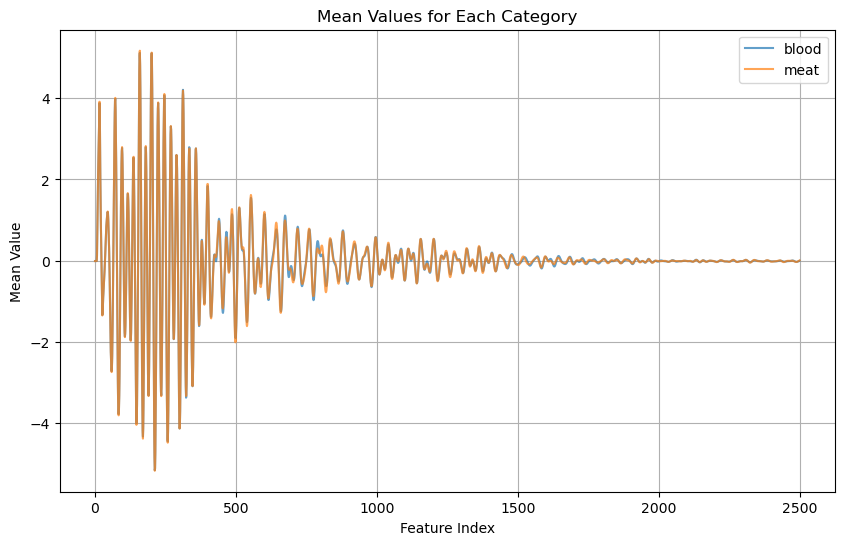

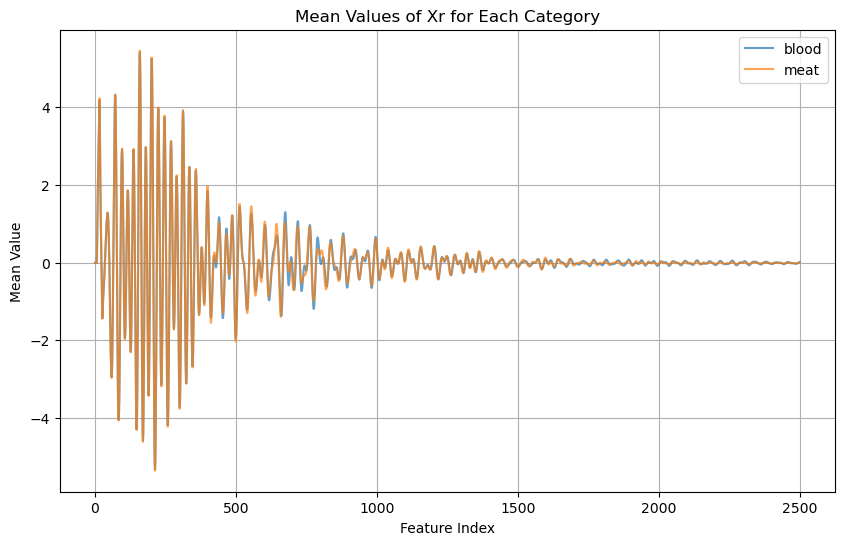

In [79]:
unique_labels = np.unique(y_train)
indices1 = {}
indices2 = {}
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(y_train.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_train[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[int(label)]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values for Each Category")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices2[materials[i]] = np.where(y_r_test.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_r_test[indices2[materials[i]]].mean(axis=0) # type: ignore
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[int(label)]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values of Xr for Each Category")
plt.legend()
plt.grid(True)
plt.show()



In [99]:
class auto_encoder(nn.Module):

    def __init__(self):
        super(auto_encoder, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 54)
        self.fc3 = nn.Linear(54, 128)
        self.fc4 = nn.Linear(128, X_train.shape[1])

        self.act = nn.PReLU()

    def forward(self, input):
        hidden1 = self.act(self.fc1(input))
        hidden2 = self.act(self.fc2(hidden1))
        hidden3 = self.act(self.fc3(hidden2))
        output = self.fc4(hidden3)
        return output
    def encoder(self, x):
        h1 = self.act(self.fc1(x))
        return self.act(self.fc2(h1))

    def decoder(self, z):
        h3 = self.act(self.fc3(z))
        return self.fc4(h3)

    
set_seed(seed)

In [100]:

auto_model = auto_encoder().to(device)
auto_criterion = nn.MSELoss()
auto_optimizer = optim.AdamW(auto_model.parameters(),lr = 1e-4)
# 4. 将 numpy 数据转为 torch 张量并移动到 device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).squeeze().to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).squeeze().to(device)
X_r_test_tensor = torch.tensor(X_r_test, dtype=torch.float32).to(device)
y_r_test_tensor = torch.tensor(y_r_test,dtype=torch.long).squeeze().to(device)

In [101]:
num_epochs = 2000
train_losses = []
test_losses = []


pbar = tqdm(range(num_epochs), desc="Training", leave=True)
for epoch in pbar:
    # —— 1. 训练 —— #
    auto_model.train()
    auto_optimizer.zero_grad()
    outputs = auto_model(X_train_tensor)
    train_loss = auto_criterion(outputs, X_train_tensor)
    train_loss.backward()
    auto_optimizer.step()
    train_losses.append(train_loss.item())
    
    # —— 2. 验证 —— #
    auto_model.eval()
    with torch.no_grad():
        test_outputs = auto_model(X_test_tensor)    # 假设你已有 X_test_tensor
        test_loss = auto_criterion(test_outputs, X_test_tensor)
        test_losses.append(test_loss.item())

    # —— 3. 更新 tqdm 的显示 —— #
    pbar.set_postfix(train_loss=train_loss.item(), test_loss=test_loss.item())

Training: 100%|██████████| 2000/2000 [01:09<00:00, 28.82it/s, test_loss=0.00409, train_loss=0.00409]


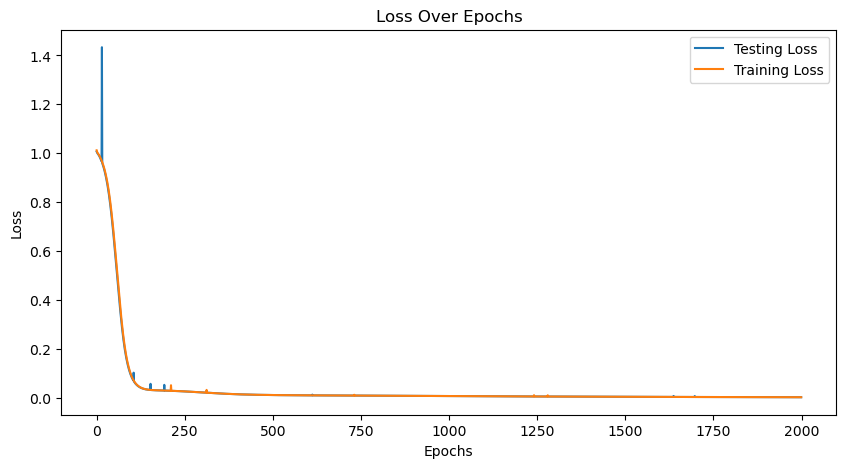

In [102]:

plt_loss(train_losses=train_losses, test_losses = test_losses)

In [139]:
X_train_auto = auto_model.encoder(X_train_tensor)
X_test_auto = auto_model.encoder(X_test_tensor)
X_r_test_auto = auto_model.encoder(X_r_test_tensor)

X_train_auto = X_train_auto.detach()
X_test_auto = X_test_auto.detach()
X_r_test_auto = X_r_test_auto.detach()

X_train_auto_np = X_train_auto.cpu().numpy()
X_r_test_auto_np = X_r_test_auto.cpu().numpy()

In [ ]:
class ANN_Model(nn.Module):

    def __init__(self):
        super(ANN_Model, self).__init__()
        self.fc1 = nn.Linear(X_train_auto.shape[1], 32)
        self.fc2 = nn.Linear(32,10)
        self.fc3 = nn.Linear(10, 2)
        self.actf = nn.ELU()


    def forward(self, i):
        h1 = self.actf(self.fc1(i))
        h2 = self.actf(self.fc2(h1))
        o = self.fc3(h2)
        return o

set_seed(seed)

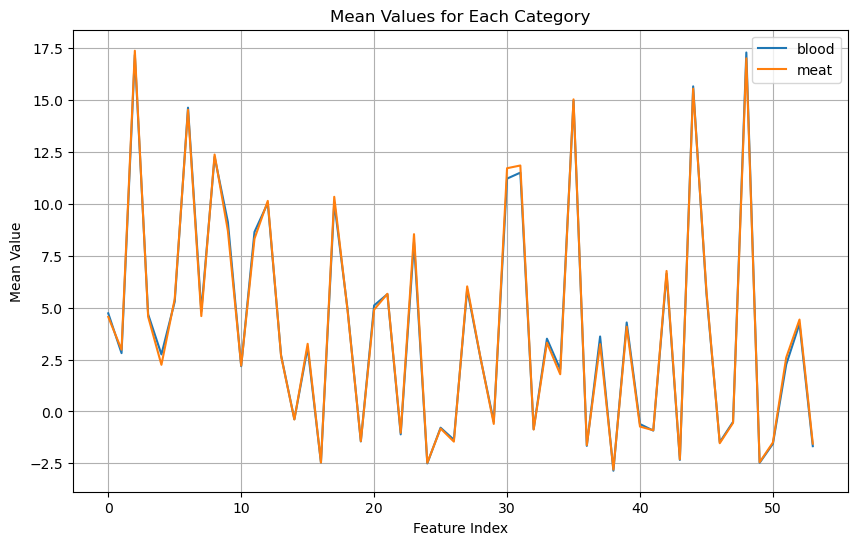

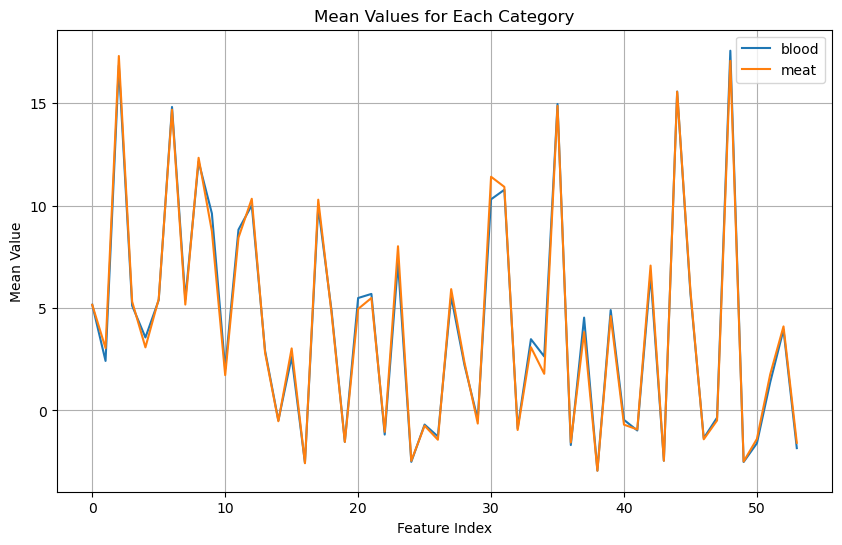

In [141]:
unique_labels = np.unique(y_train)
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_train_auto_np[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[int(label)]}")
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values for Each Category")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    mean_values = X_r_test_auto_np[indices2[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[int(label)]}")
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values for Each Category")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model = ANN_Model().to(device)

class_weights,_ = rebalance_weight(y_train)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=3e-5,weight_decay=5e-4)
# 4. 将 numpy 数据转为 torch 张量并移动到 device

In [143]:
# 5. 训练模型
num_epochs = 1.6e4
train_losses = []
verify_losses = []
lossthreshold = 0.0001
pbar = tqdm(range(int(num_epochs)), desc="Training", leave=True)
for epoch in pbar:
    optimizer.zero_grad()
    outputs = model(X_train_auto)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # —— 2. 验证 —— #
    model.eval()
    with torch.no_grad():
        verify_outputs = model(X_r_test_auto)    
        verify_loss = criterion(verify_outputs, y_r_test_tensor)
        verify_losses.append(verify_loss.item())
    # —— 3. 更新 tqdm 的显示 —— #
    pbar.set_postfix(train_loss=loss.item(), verify_loss=verify_loss.item())
    if loss < lossthreshold:
        break

Training: 100%|██████████| 16000/16000 [01:36<00:00, 165.82it/s, train_loss=0.000249, verify_loss=0.0994]


In [144]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_auto)
    train_outputs = model(X_train_auto)
    _, predicted = torch.max(test_outputs, 1)
    _, predicted_train = torch.max(train_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    predicted_np_train = predicted_train.cpu().numpy()
    accuracy_train = accuracy_score(y_train,predicted_np_train)
    accuracy = accuracy_score(y_test, predicted_np)
    cm = confusion_matrix(y_test, predicted_np)

Accuracy: 0.99975
Accuracy_train: 1.0
Confusion Matrix:
[[4002    1]
 [   1 3996]]


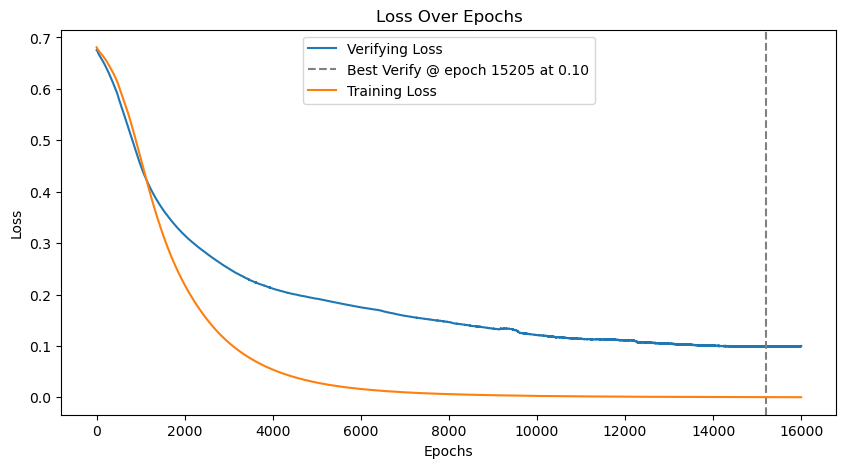

In [145]:
print(f'Accuracy: {accuracy}')
print(f'Accuracy_train: {accuracy_train}')
print(f'Confusion Matrix:\n{cm}')

plt_loss(train_losses=train_losses, verifying_losses =verify_losses)

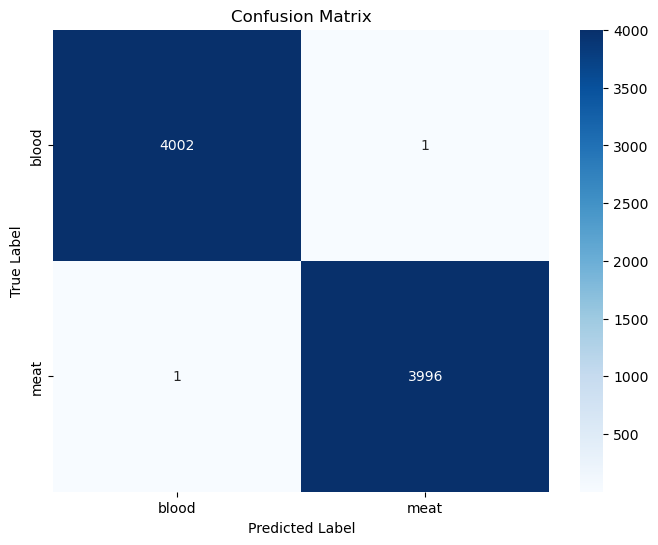

Accuracy: 0.99975
              precision    recall  f1-score   support

       blood       1.00      1.00      1.00      4003
        meat       1.00      1.00      1.00      3997

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [146]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=materials,
            yticklabels=materials)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.show()

# Convert y_test to integer labels
y_test_int = y_test.astype(int)

# Show classification reportaccuracy
report = classification_report(y_test_int, predicted_np,
                               target_names=materials, labels=range(len(materials)))
print("Accuracy:", accuracy)
print(report)

In [147]:
model.eval()
with torch.no_grad():
    r_test_outputs = model(X_r_test_auto)
    _, predicted = torch.max(r_test_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    r_accuracy = accuracy_score(y_r_test, predicted_np)
    r_cm = confusion_matrix(y_r_test, predicted_np)

Accuracy: 0.9802490124506226


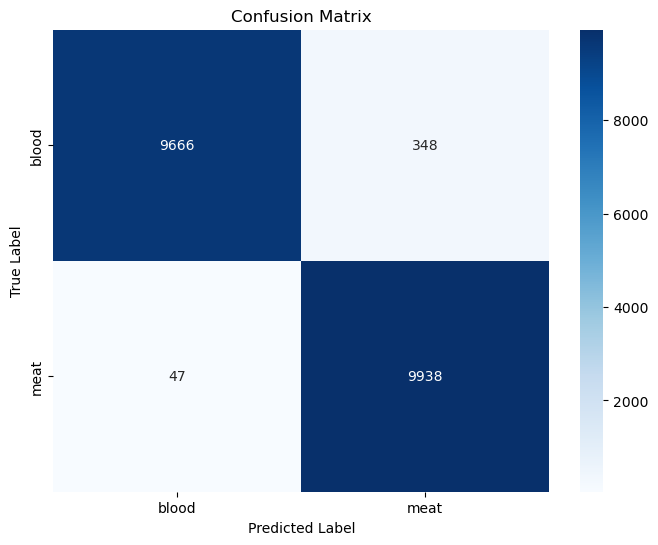

In [148]:
print(f'Accuracy: {r_accuracy}')
plt_confusion(r_cm,materials)

In [149]:
model.eval()
with torch.no_grad():
    logits = model(X_r_test_auto.to(device))    # [N,2]
    
    # 方法 A：用 softmax 概率
    probs = torch.softmax(logits, dim=1)           # [N, 2]
    all_scores = probs[:, 1].cpu().numpy()         # 正类概率 ∈ [0,1]
    all_labels = y_r_test  # shape (N,)

In [150]:
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = roc_auc_score(all_labels, all_scores)

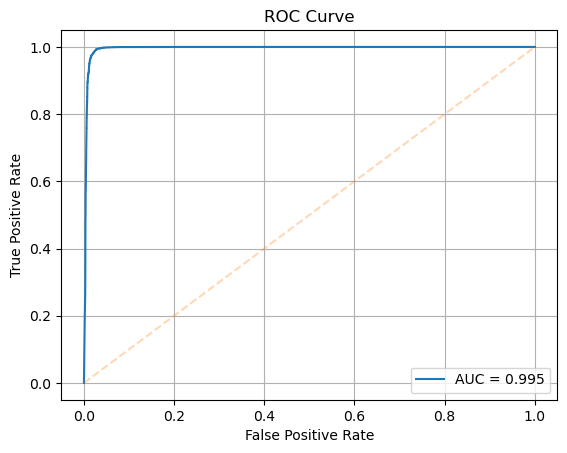

In [151]:
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--', alpha=0.3)   # 对角参考线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [152]:
# with torch.no_grad():
#     model.fc3.bias = nn.Parameter(torch.tensor([ 1, -0.0134], device='cuda:0', requires_grad=True))
#     print(model.fc3.bias)

In [153]:
# model.eval()
# with torch.no_grad():
#     r_test_outputs = model(X_test_tensor)
#     _, predicted = torch.max(r_test_outputs, 1)
#     predicted_np = predicted.cpu().numpy()
#     r_accuracy = accuracy_score(y_test, predicted_np)
#     r_cm = confusion_matrix(y_test, predicted_np)
# print(f'Accuracy: {r_accuracy}')
# plt_confusion(r_cm,materials)